In [ ]:
from io import open
import unicodedata
import string
import random
import re

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Subset
from torch.utils.data import TensorDataset, DataLoader
import time, copy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Here we download and unzip the text file that contains all of our translated phrases
!rm spa-eng.zip _about.txt spa.txt
!wget https://www.manythings.org/anki/spa-eng.zip
!unzip spa-eng.zip
!ls

rm: cannot remove 'spa-eng.zip': No such file or directory
rm: cannot remove '_about.txt': No such file or directory
rm: cannot remove 'spa.txt': No such file or directory
--2025-01-21 04:30:39--  https://www.manythings.org/anki/spa-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5420295 (5.2M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   5.17M  16.8MB/s    in 0.3s    

2025-01-21 04:30:40 (16.8 MB/s) - ‘spa-eng.zip’ saved [5420295/5420295]

Archive:  spa-eng.zip
  inflating: _about.txt              
  inflating: spa.txt                 
_about.txt  sample_data  spa-eng.zip  spa.txt


In [ ]:
# Helper functions combined from PyTorch tutorial: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
# This is important because we want all words to be formatted the same similar
# to our image normalization
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r"", s)
    s = re.sub(r"[^a-zA-Z.!'?]+", r" ", s)
    return s

def parse_data(filename):
    # Read the file and split into lines
    lines = open(filename, encoding='utf-8').read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    # Throw out the attribution as it is not a part of the data
    pairs = [[pair[0], pair[1]] for pair in pairs]

    return pairs

In [ ]:
pairs = parse_data("spa.txt")
# We only want the english sentences because we aren't translating
english_sentences = [pair[0] for pair in pairs]
# Shuffle our dataset
random.shuffle(english_sentences)
print("Number of English sentences:", len(english_sentences))

Number of English sentences: 141543


In [ ]:
# Since we already shuffled our dataset, grab a random sampling of sentences for our train, val, and test
# Here we are using a small number of Sentences to ease training time. Feel free to use more
train_sentences = english_sentences[:1000]
val_sentences = english_sentences[1000:2000]
test_sentences = english_sentences[2000:3000]

# Using this function we will create a dictionary to use for our one hot encoding vectors
def add_words_to_dict(word_dictionary, word_list, sentences):
    for sentence in sentences:
        for word in sentence.split(" "):
            if word in word_dictionary:
                continue
            else:
                word_list.append(word)
                word_dictionary[word] = len(word_list)-1

english_dictionary = {}
english_list = []
add_words_to_dict(english_dictionary, english_list, train_sentences)
add_words_to_dict(english_dictionary, english_list, val_sentences)
add_words_to_dict(english_dictionary, english_list, test_sentences)



In [ ]:
# Now make our training samples:
def create_input_tensor(sentence, word_dictionary):
    words = sentence.split(" ")
    tensor = torch.zeros(len(words), 1, len(word_dictionary)+1)
    for idx in range(len(words)):
        word = words[idx]
        tensor[idx][0][word_dictionary[word]] = 1
    return tensor

def create_target_tensor(sentence, word_dictionary):
    words = sentence.split(" ")
    tensor = torch.zeros(len(words), 1, len(word_dictionary)+1)
    for idx in range(1, len(words)):
        word = words[idx]
        if word not in word_dictionary:
            print("Error: This word is not in our dataset - using a zeros tensor")
            continue
        tensor[idx-1][0][word_dictionary[word]] = 1
    tensor[len(words)-1][0][len(word_dictionary)] = 1 # EOS
    return tensor


train_tensors = [(create_input_tensor(sentence, english_dictionary), create_target_tensor(sentence, english_dictionary)) for sentence in train_sentences]
val_tensors = [(create_input_tensor(sentence, english_dictionary), create_target_tensor(sentence, english_dictionary)) for sentence in val_sentences]
test_tensors = [(create_input_tensor(sentence, english_dictionary), create_target_tensor(sentence, english_dictionary)) for sentence in test_sentences]

In [ ]:
k1 = torch.zeros(5, 2, 3)
print(k1)

tensor([[[0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.]]])


In [ ]:
def tensor_to_sentence(word_list, tensor):
    sentence = ""
    for i in range(tensor.size(0)):
        topv, topi = tensor[i].topk(1)
        if topi[0][0] == len(word_list):
            sentence += "<EOS>"
            break
        sentence += word_list[topi[0][0]]
        sentence += " "
    return sentence

print("This code helps visualize which words represent an input_tensor and its corresponding target_tensor!")
examples_to_show = 6
count = 1
for input, target in train_tensors:
    print(tensor_to_sentence(english_list, input))
    print(tensor_to_sentence(english_list, target))
    count +=1
    if count > examples_to_show:
        break

This code helps visualize which words represent an input_tensor and its corresponding target_tensor!
i didn't get his joke 
didn't get his joke <EOS>
she is shy of strangers 
is shy of strangers <EOS>
the prices here are very reasonable 
prices here are very reasonable <EOS>
i know that you are learning french at school 
know that you are learning french at school <EOS>
my conscience bothers me 
conscience bothers me <EOS>
we need to protect tom 
need to protect tom <EOS>


In [ ]:
# Let's look at a few sentence encodings, to see what those look like:
for i in range(6):
    print(train_sentences[i], "[encode as]", train_tensors[i][0])

i didn't get his joke [encode as] tensor([[[1., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 1., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 1.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]]])
she is shy of strangers [encode as] tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]]])
the prices here are very reasonable [encode as] tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]]])
i know that you are learning french at school [encode as] tensor([[[1., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

       

In [ ]:
dataloaders = {'train': train_tensors,
               'val': val_tensors,
               'test': test_tensors}

dataset_sizes = {'train': len(train_tensors),
                 'val': len(val_tensors),
                 'test': len(test_tensors)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 1000, 'val': 1000, 'test': 1000}


In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2)

        self.hidden_size = hidden_size

        #self.rnn = nn.RNN(input_size, hidden_size, num_layers = 1, nonlinearity = 'tanh', dropout = 0)

        self.fc = nn.Linear(hidden_size, output_size)
        # TODO

    def forward(self, input, hidden):
        #h0 = torch.zeros(1, input.size(0), self.lstm.hidden_size)
        #c0 = torch.zeros(1, input.size(0), self.lstm.hidden_size)
        output, hidden = self.lstm(input, hidden)
        out = self.fc(output)  # Use the last output of the sequence
        return out, hidden

    def initHidden(self):
        # We need two hidden layers because of our two layered lstm!
        # Your model should be able to use this implementation of initHidden()
        return (torch.zeros(2, self.hidden_size).to(device), torch.zeros(2, self.hidden_size).to(device))

In [ ]:
def train_lstm(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # keep the best weights stored separately
    best_loss = np.inf
    best_epoch = 0

    # Each epoch has a training, validation, and test phase
    phases = ['train', 'val', 'test']

    # Keep track of how loss evolves during training
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data
            for input_sequence, target_sequence in dataloaders[phase]:
                # Now Iterate through each sequence here:

                hidden = model.initHidden() # Start with a fresh hidden state

                current_input_sequence = input_sequence.to(device)
                current_target_sequence = target_sequence.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    loss = 0
                    # Make a prediction for each element in the sequence,
                    # keeping track of the hidden state along the way
                    for i in range(current_input_sequence.size(0)):
                        # Need to be clever with how we transfer our hidden layers to the device
                        current_hidden = (hidden[0].to(device), hidden[1].to(device))
                        output, hidden = model(current_input_sequence[i], current_hidden)
                        l = criterion(output, current_target_sequence[i])
                        loss += l

                    # backward + update weights only if in training phase at the end of a sequence
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() / current_input_sequence.size(0)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)

            print(f'{phase:5} Loss: {epoch_loss:.4f}')

            # deep copy the model if it's the best loss
            # Note: We are using the train loss here to determine our best model
            if phase == 'train' and epoch_loss < best_loss:
              best_epoch = epoch
              best_loss = epoch_loss
              best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Loss: {best_loss:4f} at epoch {best_epoch}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, training_curves

In [ ]:
# We define our predict function here so that we can run some predictions in the same cell as our training!
def predict(model, word_dictionary, word_list, input_sentence, max_length = 20):
    output_sentence = input_sentence + " "
    tensor = create_input_tensor(input_sentence, word_dictionary)
    hidden = model.initHidden()
    current_input_sequence = tensor.to(device)
    input = None

    for i in range(current_input_sequence.size(0)):
        current_hidden = (hidden[0].to(device), hidden[1].to(device))
        output, hidden = model(current_input_sequence[i], current_hidden)

    topv, topi = output.topk(1)
    topi = topi[0][0]
    if topi ==  len(word_dictionary):
        topv, topi = output.topk(2)
        topi = topi[0][1]
    word = word_list[topi]
    output_sentence += word
    output_sentence += " "
    input = create_input_tensor(word, word_dictionary)

    for i in range(len(input_sentence.split(" ")), max_length):
        current_hidden = (hidden[0].to(device), hidden[1].to(device))
        current_input = input[0].to(device)
        output, hidden = model(current_input, current_hidden)
        topv, topi = output.topk(1)
        topi = topi[0][0]
        if topi == len(word_dictionary):
            # print("Hit the EOS")
            break
        word = word_list[topi]
        output_sentence += word
        output_sentence += " "
        input = create_input_tensor(word, word_dictionary)
    return output_sentence

In [ ]:
len(english_list)

2682

In [25]:
# TODO: Fill in the necessary code to execute the training function
"""
Your Code Below:
"""
# This should look very similar to our previous tasks!
learning_rate = 0.011
num_epochs = 15

# TODO
lstm = LSTM(len(english_list)+1, 256, len(english_list)+1).to(device)

# loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

lstm, training_curves = train_lstm(lstm, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/15
----------
train Loss: 5.9280
val   Loss: 5.7217
test  Loss: 5.6862

Epoch 2/15
----------
train Loss: 4.8040
val   Loss: 5.9865
test  Loss: 5.9498

Epoch 3/15
----------
train Loss: 4.0983
val   Loss: 6.8038
test  Loss: 6.7591

Epoch 4/15
----------
train Loss: 3.5832
val   Loss: 7.4182
test  Loss: 7.3461

Epoch 5/15
----------
train Loss: 3.0838
val   Loss: 8.4607
test  Loss: 8.4058

Epoch 6/15
----------
train Loss: 2.7197
val   Loss: 8.5737
test  Loss: 8.5310

Epoch 7/15
----------
train Loss: 2.3583
val   Loss: 8.6324
test  Loss: 8.5557

Epoch 8/15
----------
train Loss: 2.0770
val   Loss: 8.9599
test  Loss: 8.8620

Epoch 9/15
----------
train Loss: 1.8242
val   Loss: 9.4785
test  Loss: 9.3499

Epoch 10/15
----------
train Loss: 1.5682
val   Loss: 9.7336
test  Loss: 9.5382

Epoch 11/15
----------
train Loss: 1.3829
val   Loss: 9.8265
test  Loss: 9.7275

Epoch 12/15
----------
train Loss: 1.2057
val   Loss: 10.1543
test  Loss: 10.0086

Epoch 13/15
----------
train Loss:

In [26]:
print(predict(lstm, english_dictionary, english_list, "what is"))
print(predict(lstm, english_dictionary, english_list, "my name"))
print(predict(lstm, english_dictionary, english_list, "how are"))
#print(predict(lstm, english_dictionary, english_list, "hi"))
print(predict(lstm, english_dictionary, english_list, "choose"))

what is the last time you cooked 
my name wants a can you a little attended 
how are you tomorrow 
choose up these false 


In [27]:
def plot_training_curves(training_curves,
                         phases=['train', 'val', 'test'],
                         metrics=['loss']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                plt.plot(epochs, training_curves[key])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

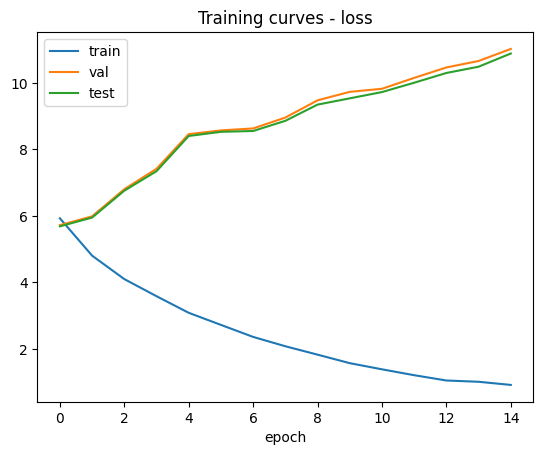

In [28]:
plot_training_curves(training_curves, phases=['train', 'val', 'test'])